In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchsummary import summary
print(torch.__version__)

2.6.0+cu124


In [ ]:
batch_size = 12
epoches = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current Device = ",device)

Current Device =  cuda


In [ ]:
transforms = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
training_data = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform=transforms)
validation_data = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform=transforms)

In [ ]:
training_loader = DataLoader(dataset = training_data, batch_size = batch_size, shuffle=True)
validation_loader = DataLoader(dataset = validation_data, batch_size = batch_size, shuffle=True)

In [ ]:
print("Traning Dataset Size = ", len(training_loader))
print("Validation Dataset Size = ", len(validation_loader))

Traning Dataset Size =  5000
Validation Dataset Size =  834


In [ ]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

In [ ]:
images.shape

torch.Size([12, 1, 28, 28])

9 images with shape 1 channel, 28px height, 28px width

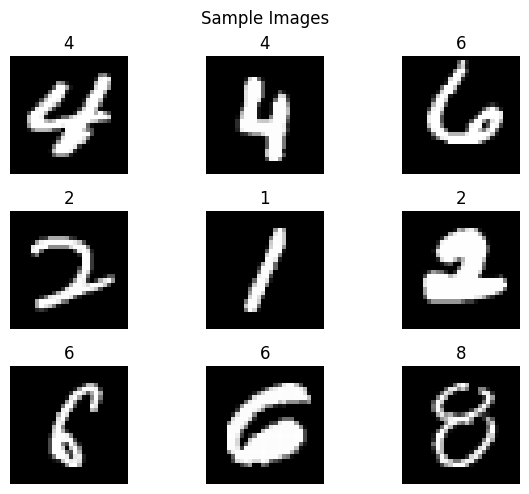

In [ ]:
npimgs = [np.transpose(images[j].numpy(),(1,2,0)) for j in range(0,9)]

num_img_along_ax = 3
fig, ax = plt.subplots(nrows = num_img_along_ax,ncols = num_img_along_ax)

for idx, (img, label) in enumerate(zip(npimgs, labels)):
    row = idx // num_img_along_ax
    col = idx % num_img_along_ax

    ax[row][col].imshow(img, cmap='gray')
    ax[row][col].set_title(str(label.item()))
    ax[row][col].axis('off')

plt.tight_layout()
plt.suptitle("Sample Images", y = 1.02)
plt.show()

In [ ]:
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, inp_shape=784):
        super().__init__()
        self.Network = nn.Sequential(
            nn.Linear(inp_shape, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 10)  # 10 classes for MNIST
            # the loss function itself calculates the softmax, so we just pass in the logits
        )

    def forward(self, X):
        X = X.view(X.size(0), -1)  # Flatten (batch_size, 784)
        return self.Network(X)

In [ ]:
model = NeuralNetwork(784)

In [ ]:
model.to(device)

NeuralNetwork(
  (Network): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_of_batches = int((len(training_loader)/batch_size)+(len(training_loader)%batch_size))

In [ ]:
num_of_batches

424

In [ ]:
Loss_per_batch = []
Accuracy_per_batch = []

for i in range(epoches):
  TotalLoss = 0
  TotalAccuracy = 0
  for batch, (X,y) in enumerate(training_loader):

    X, y = X.to(device), y.to(device)

    logits = model(X)

    loss = loss_fn(logits, y) # we just need to pass logits the loss function as it applies softmax itself

    y_pred = torch.argmax(F.softmax(logits,dim = 1),dim = 1) # calculating this for training accuracy

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    TotalLoss += loss.item()
    TotalAccuracy += (accuracy_score(y.cpu(),y_pred.cpu()))

  print(f"For epoch no. {i+1} average loss = {TotalLoss/num_of_batches}")

  Loss_per_batch.append(TotalLoss/num_of_batches)
  Accuracy_per_batch.append((TotalAccuracy/num_of_batches))

For epoch no. 1 average loss = 8.874200327128595
For epoch no. 2 average loss = 3.5671884138202996
For epoch no. 3 average loss = 2.655004640935727
For epoch no. 4 average loss = 2.119505742380839
For epoch no. 5 average loss = 1.7706632390258645
For epoch no. 6 average loss = 1.5619405544121894
For epoch no. 7 average loss = 1.3918891913950264
For epoch no. 8 average loss = 1.2493761965619479
For epoch no. 9 average loss = 1.1440855613744236
For epoch no. 10 average loss = 1.0455864000700186
For epoch no. 11 average loss = 0.9660291337792652
For epoch no. 12 average loss = 0.9266824632576796
For epoch no. 13 average loss = 0.8355872790060566
For epoch no. 14 average loss = 0.7783592080362174
For epoch no. 15 average loss = 0.7606589926212761


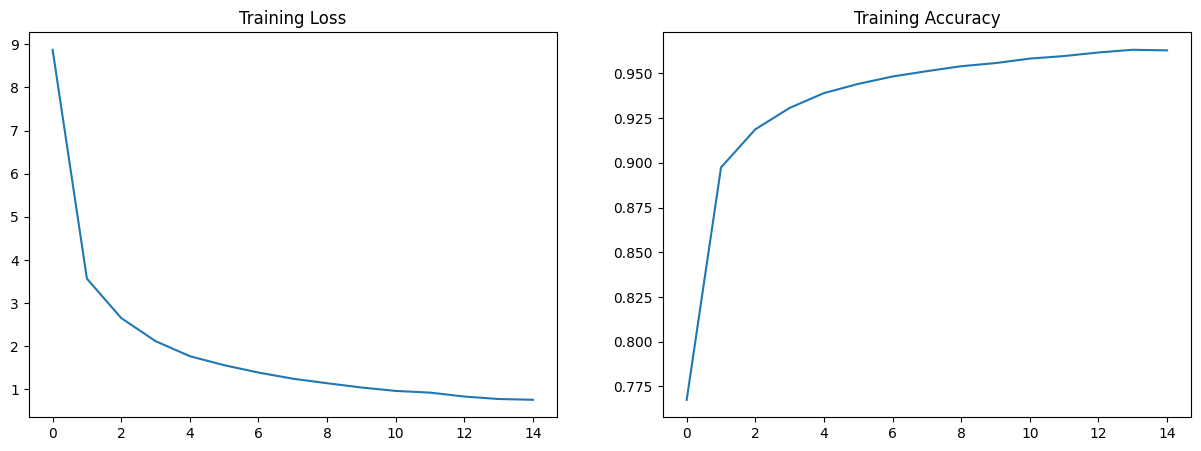

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax1.plot(range(0,epoches),Loss_per_batch)
ax1.set_title("Training Loss")
ax2.plot(range(0,epoches),Accuracy_per_batch)
ax2.set_title("Training Accuracy")
plt.show()

In [ ]:
ValLoss = 0
TotalAccuracy = 0
num_of_val_batches = len(validation_loader)/batch_size + len(validation_loader)%batch_size
for batch, (X,y) in enumerate(validation_loader):
  model.eval()
  X, y = X.to(device), y.to(device)
  with torch.no_grad():
    logits = model(X)
    probs = F.softmax(logits,1)
    preds = torch.argmax(probs,1)

    ValLoss += loss.item()
    TotalAccuracy += accuracy_score(y.cpu(), preds.cpu())
print(f"average validation loss = {ValLoss/num_of_val_batches}")
print(f"average accuracy loss = {TotalAccuracy/len(validation_loader)}")

average validation loss = 2.071874663924539
average accuracy loss = 0.9798161470823326


In [ ]:
def make_prediction(img):
  model.eval()
  with torch.no_grad():
    logits = model(img)
    probs = F.softmax(logits,1)
    preds = torch.argmax(probs,1)
    return preds.item()

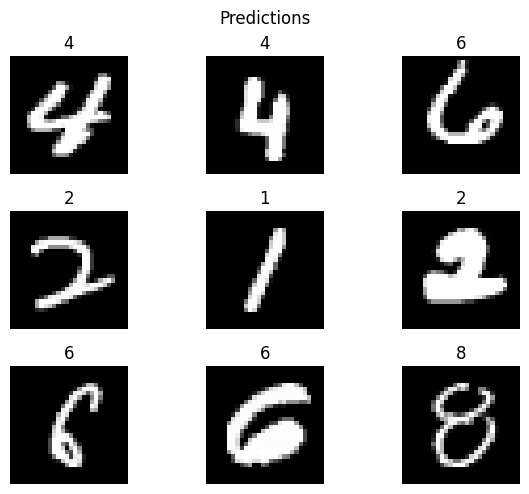

In [ ]:
num_img_along_ax = 3
fig, ax = plt.subplots(nrows = num_img_along_ax,ncols = num_img_along_ax)

for idx, img in enumerate(images[:9]):
    row = idx // num_img_along_ax
    col = idx % num_img_along_ax

    ax[row][col].imshow(np.transpose(img.numpy(),(1,2,0)), cmap='gray')
    ax[row][col].set_title(str(make_prediction(img.to(device))))
    ax[row][col].axis('off')

plt.tight_layout()
plt.suptitle('Predictions',y = 1.02)
plt.show()